# PaddleOCR DJL example

In this tutorial, we will be using pretrained PaddlePaddle model from [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) to do Optical character recognition (OCR) from the given image. There are three models involved in this tutorial:

- Word detection model: used to detect the word block from the image
- Word direction model: used to find if the text needs to rotate
- Word recognition model: Used to recognize test from the word block

## Import dependencies and classes

PaddlePaddle is one of the Deep Engines that requires DJL hybrid mode to run inference. Itself does not contains NDArray operations and needs a supplemental DL framework to help with that. So we import Pytorch DL engine as well in here to do the processing works.

In [1]:
// %mavenRepo snapshots https://oss.sonatype.org/content/repositories/snapshots/

%maven ai.djl:api:0.22.1
%maven ai.djl.paddlepaddle:paddlepaddle-model-zoo:0.22.1
%maven org.slf4j:slf4j-simple:1.7.32

// second engine to do preprocessing and postprocessing
%maven ai.djl.pytorch:pytorch-engine:0.22.1

In [2]:
import ai.djl.*;
import ai.djl.inference.Predictor;
import ai.djl.modality.Classifications;
import ai.djl.modality.cv.Image;
import ai.djl.modality.cv.ImageFactory;
import ai.djl.modality.cv.output.*;
import ai.djl.modality.cv.util.NDImageUtils;
import ai.djl.ndarray.*;
import ai.djl.ndarray.types.DataType;
import ai.djl.ndarray.types.Shape;
import ai.djl.repository.zoo.*;
import ai.djl.paddlepaddle.zoo.cv.objectdetection.PpWordDetectionTranslator;
import ai.djl.paddlepaddle.zoo.cv.imageclassification.PpWordRotateTranslator;
import ai.djl.paddlepaddle.zoo.cv.wordrecognition.PpWordRecognitionTranslator;
import ai.djl.translate.*;
import java.util.concurrent.ConcurrentHashMap;

## the Image
Firstly, let's take a look at our sample image, a flight ticket:

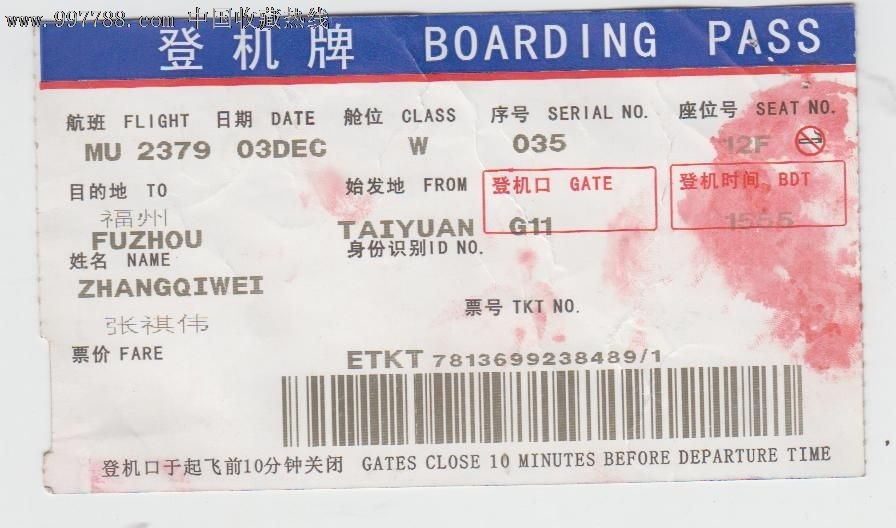

In [3]:
String url = "https://resources.djl.ai/images/flight_ticket.jpg";
Image img = ImageFactory.getInstance().fromUrl(url);
img.getWrappedImage();

## Word detection model

In our word detection model, we load the model exported from [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.0/doc/doc_en/inference_en.md#convert-detection-model-to-inference-model). After that, we can spawn a DJL Predictor from it called detector.

In [4]:
var criteria1 = Criteria.builder()
        .optEngine("PaddlePaddle")
        .setTypes(Image.class, DetectedObjects.class)
        .optModelUrls("https://resources.djl.ai/test-models/paddleOCR/mobile/det_db.zip")
        .optTranslator(new PpWordDetectionTranslator(new ConcurrentHashMap<String, String>()))
        .build();
var detectionModel = criteria1.loadModel();
var detector = detectionModel.newPredictor();

[IJava-executor-0] INFO ai.djl.paddlepaddle.jni.LibUtils - Downloading https://publish.djl.ai/paddlepaddle-2.3.2/cpu/linux/native/lib/libpaddle2onnx.so.1.0.0rc2.gz ...
[IJava-executor-0] INFO ai.djl.paddlepaddle.jni.LibUtils - Downloading https://publish.djl.ai/paddlepaddle-2.3.2/cpu/linux/native/lib/libpaddle_inference.so.gz ...
[IJava-executor-0] INFO ai.djl.paddlepaddle.jni.LibUtils - Downloading https://publish.djl.ai/paddlepaddle-2.3.2/cpu/linux/native/lib/libonnxruntime.so.gz ...
[IJava-executor-0] INFO ai.djl.paddlepaddle.jni.LibUtils - Downloading https://publish.djl.ai/paddlepaddle-2.3.2/cpu/linux/native/lib/libonnxruntime.so.1.11.1.gz ...
[IJava-executor-0] INFO ai.djl.paddlepaddle.jni.LibUtils - Downloading https://publish.djl.ai/paddlepaddle-2.3.2/cpu/linux/native/lib/libpaddle2onnx.so.gz ...
[IJava-executor-0] INFO ai.djl.paddlepaddle.jni.LibUtils - Paddle MKL/GPU requires user to set LD_LIBRARY_PATH=/home/jovyan/.djl.ai/paddle/2.3.2-cpu-linux-x86_64, the current one is se

Then, we can detect the word block from it. The original output from the model is a bitmap that marked all word regions. The `PpWordDetectionTranslator` convert the output bitmap into a rectangle bounded box for us to crop the image.

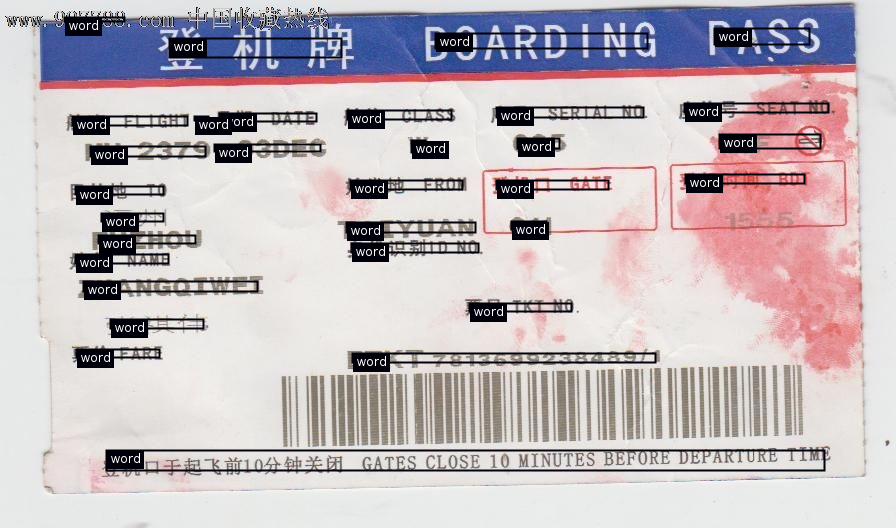

In [5]:
var detectedObj = detector.predict(img);
Image newImage = img.duplicate();
newImage.drawBoundingBoxes(detectedObj);
newImage.getWrappedImage();

As you can see above, the word block are very narrow and does not include the whole body of all words. Let's try to extend it a bit for a better result. `extendRect` extend the box height and width to a certain scale. `getSubImage` will crop the image and extract the word block.

In [6]:
Image getSubImage(Image img, BoundingBox box) {
    Rectangle rect = box.getBounds();
    double[] extended = extendRect(rect.getX(), rect.getY(), rect.getWidth(), rect.getHeight());
    int width = img.getWidth();
    int height = img.getHeight();
    int[] recovered = {
        (int) (extended[0] * width),
        (int) (extended[1] * height),
        (int) (extended[2] * width),
        (int) (extended[3] * height)
    };
    return img.getSubImage(recovered[0], recovered[1], recovered[2], recovered[3]);
}

double[] extendRect(double xmin, double ymin, double width, double height) {
    double centerx = xmin + width / 2;
    double centery = ymin + height / 2;
    if (width > height) {
        width += height * 2.0;
        height *= 3.0;
    } else {
        height += width * 2.0;
        width *= 3.0;
    }
    double newX = centerx - width / 2 < 0 ? 0 : centerx - width / 2;
    double newY = centery - height / 2 < 0 ? 0 : centery - height / 2;
    double newWidth = newX + width > 1 ? 1 - newX : width;
    double newHeight = newY + height > 1 ? 1 - newY : height;
    return new double[] {newX, newY, newWidth, newHeight};
}

Let's try to extract one block out:

In [7]:
List<DetectedObjects.DetectedObject> boxes = detectedObj.items();
var sample = getSubImage(img, boxes.get(5).getBoundingBox());
sample.getWrappedImage();

## Word Direction model

This model is exported from [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.0/doc/doc_en/inference_en.md#convert-angle-classification-model-to-inference-model) that can help to identify if the image is required to rotate. The following code will load this model and create a rotateClassifier.

In [8]:
var criteria2 = Criteria.builder()
        .optEngine("PaddlePaddle")
        .setTypes(Image.class, Classifications.class)
        .optModelUrls("https://resources.djl.ai/test-models/paddleOCR/mobile/cls.zip")
        .optTranslator(new PpWordRotateTranslator())
        .build();
var rotateModel = criteria2.loadModel();
var rotateClassifier = rotateModel.newPredictor();

## Word Recgonition model

The word recognition model is exported from [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.0/doc/doc_en/inference_en.md#convert-recognition-model-to-inference-model) that can recognize the text on the image. Let's load this model as well.


In [9]:
var criteria3 = Criteria.builder()
        .optEngine("PaddlePaddle")
        .setTypes(Image.class, String.class)
        .optModelUrls("https://resources.djl.ai/test-models/paddleOCR/mobile/rec_crnn.zip")
        .optTranslator(new PpWordRecognitionTranslator())
        .build();
var recognitionModel = criteria3.loadModel();
var recognizer = recognitionModel.newPredictor();

Then we can try to play with these two models on the previous cropped image:

In [10]:
System.out.println(rotateClassifier.predict(sample));
recognizer.predict(sample);

[
	{"class": "Rotate", "probability": 0.52805}
	{"class": "No Rotate", "probability": 0.47194}
]


序号SERIALNO.

Finally, let's run these models on the whole image and see the outcome. DJL offers a rich image toolkit that allows you to draw the text on image and display them.

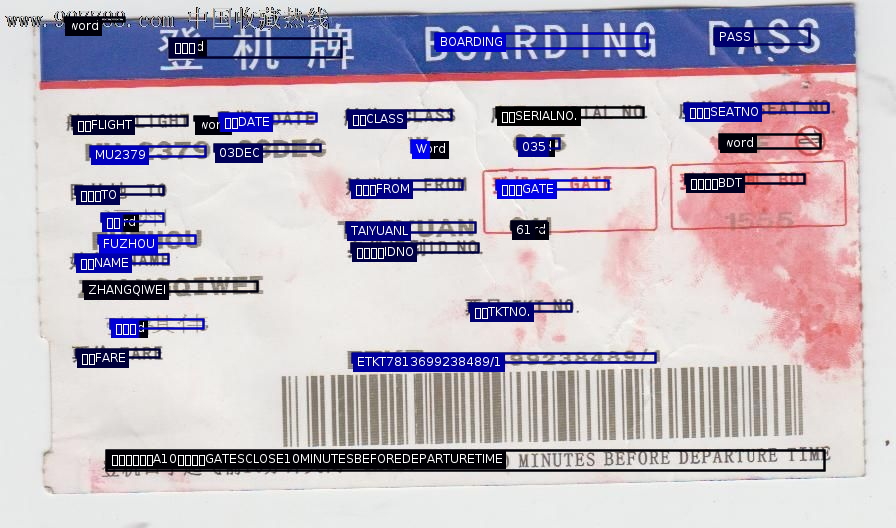

In [11]:
Image rotateImg(Image image) {
    try (NDManager manager = NDManager.newBaseManager()) {
        NDArray rotated = NDImageUtils.rotate90(image.toNDArray(manager), 1);
        return ImageFactory.getInstance().fromNDArray(rotated);
    }
}

List<String> names = new ArrayList<>();
List<Double> prob = new ArrayList<>();
List<BoundingBox> rect = new ArrayList<>();

for (int i = 0; i < boxes.size(); i++) {
    Image subImg = getSubImage(img, boxes.get(i).getBoundingBox());
    if (subImg.getHeight() * 1.0 / subImg.getWidth() > 1.5) {
        subImg = rotateImg(subImg);
    }
    Classifications.Classification result = rotateClassifier.predict(subImg).best();
    if ("Rotate".equals(result.getClassName()) && result.getProbability() > 0.8) {
        subImg = rotateImg(subImg);
    }
    String name = recognizer.predict(subImg);
    names.add(name);
    prob.add(-1.0);
    rect.add(boxes.get(i).getBoundingBox());
}
newImage.drawBoundingBoxes(new DetectedObjects(names, prob, rect));
newImage.getWrappedImage();